# Modelo de inteligencia artificial de PawSense TF

## Preparación del entorno

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import glob
import os
from PIL import Image

## Ingeniería de datos (recortado de imágenes).

In [9]:
# Patron buscar subcarpetas
xml_pattern = r"dataset_perros/annotations/Annotation/**/*"

# Para cada path parsea arquitectura xml y de ahi obtenemos desde la raiz las medidas del perro en las imagenes
for xmlpath in glob.glob(xml_pattern, recursive=True):
    # Para que no se salga de la carpeta
    if os.path.isdir(xmlpath):
        continue

    try:
        # Estructura, raiz y objeto
        tree = ET.parse(xmlpath)
        root = tree.getroot()

        obj = root.find('object')
        
        if obj is not None:

            # Sacamos medidas del perro en la foto
            box = obj.find('bndbox')
            raza = obj.find('name').text

            xmin = int(box.find('xmin').text)
            xmax = int(box.find('xmax').text)
            ymin = int(box.find('ymin').text)
            ymax = int(box.find('ymax').text)

            # En vez de coger el nombre del xml (había xml con nombres distinto del nombre de archivos de imágenes) lo coge directamente del archivo
            xml_filename = os.path.basename(xmlpath)
            imgname = os.path.splitext(xml_filename)[0] # Nombre archivo sin extension
            
            # El nombre de la carpeta padre del xml debe coincidir con la carpeta de la imagen
            imgfoldername = os.path.basename(os.path.dirname(xmlpath))

            # Patron para buscar imágenes por carpeta e imagen obtenida del nombre del archivo
            img_pattern = rf"dataset_perros/images/Images/{imgfoldername}/{imgname}.jpg"

            encontrados = glob.glob(img_pattern)
            if not encontrados:
                print(f"Procesando archivo: {xmlpath}")
                print(f"❌ No se encontró imagen para: {imgname} en {imgfoldername}")

            # Para cada path abre la imagen, asegura de que este en colores, redimensiona a lo especificado en cml (por si acaso), reajusta calidad y recorta la imágen.
            for imgpath in glob.glob(img_pattern, recursive=True):
                img = Image.open(imgpath).convert('RGB')

                # Reajustar medidas de imagen para evitar problemas de recorte
                width, height = img.size
                xml_w = int(root.find('size/width').text)
                xml_h = int(root.find('size/height').text)
                if width != xml_w or height != xml_h:
                    img = img.resize((xml_w, xml_h), Image.LANCZOS)
                
                # Recorte de imágen
                img_final = img.crop((xmin, ymin, xmax, ymax)).resize((224, 224), Image.LANCZOS)

                # Crea directorio con carpetas de nombres de raza
                output_dir = os.path.join("dataset_recortado", raza)
                os.makedirs(output_dir, exist_ok=True)
               
                # Guarda imágenes
                save_path = os.path.join(output_dir, f"{imgname}.jpg")
                img_final.save(save_path)
    except Exception as e:
        print(f"Saltando {xmlpath} por error: {e}")

## División de entrenamiento y validación.

In [10]:
# Establecemos numero de imagenes que lee a la vez (no muy alto)
batch_size = 32

# Entrenamiento (80%)
train_ds = tf.keras.utils.image_dataset_from_directory(
    "dataset_recortado",
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(224, 224),
    batch_size=batch_size
)

# Validación (20%)
val_ds = tf.keras.utils.image_dataset_from_directory(
    "dataset_recortado",
    validation_split=0.2,
    subset="validation",   
    seed=42,               
    image_size=(224, 224),
    batch_size=batch_size
)

# AUTOTUNE hace que decida cuantos recursos usar
AUTOTUNE = tf.data.AUTOTUNE

# Guarda imágenes en memoria RAM después cargarla la primera vez (en primer epoch) y prepara siguiente lote en segundo plano
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 20580 files belonging to 120 classes.
Using 16464 files for training.
Found 20580 files belonging to 120 classes.
Using 4116 files for validation.


### Aumentado de datos + Construccion del modelo + Entrenamiento

In [11]:
from tensorflow.keras import layers, models

# 1. Capa de Aumento de Datos (El Adobo)
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

# 2. Base Model: EfficientNetB0
base_model = tf.keras.applications.EfficientNetB0(
    weights='imagenet', 
    include_top=False, 
    input_shape=(224, 224, 3)
)

# --- ETAPA A: EL CALENTAMIENTO ---
base_model.trainable = False  # Congelamos al experto

model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(), # El "aplanado inteligente"
    layers.Dropout(0.3),             # Evitamos que las neuronas se acomoden
    layers.Dense(120, activation='softmax') # Las 120 razas
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Iniciando Etapa A: Entrenamiento de la cabeza...")
history_a = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=8
)

# --- ETAPA B: EL AJUSTE FINO (Fine-Tuning) ---
# Descongelamos de la capa 100 en adelante
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # LR muy bajo
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks: El vigilante
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)
]

print("Iniciando Etapa B: Fine-Tuning...")
history_b = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=callbacks
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Iniciando Etapa A: Entrenamiento de la cabeza...
Epoch 1/8
515/515 ━━━━━━━━━━━━━━━━━━━━ 401s 713ms/step - accuracy: 0.5832 - loss: 1.7902 - val_accuracy: 0.8292 - val_loss: 0.6445
Epoch 2/8
515/515 ━━━━━━━━━━━━━━━━━━━━ 361s 701ms/step - accuracy: 0.7340 - loss: 0.9288 - val_accuracy: 0.8535 - val_loss: 0.5081
Epoch 3/8
515/515 ━━━━━━━━━━━━━━━━━━━━ 320s 622ms/step - accuracy: 0.7666 - loss: 0.7892 - val_accuracy: 0.8518 - val_loss: 0.4791
Epoch 4/8
515/515 ━━━━━━━━━━━━━━━━━━━━ 323s 627ms/step - accuracy: 0.7814 - loss: 0.7380 - val_accuracy: 0.8571 - val_loss: 0.4613
Epoch 5/8
515/515 ━━━━━━━━━━━━━━━━━━━━ 309s 600ms/step - accuracy: 0.7894 - loss: 0.6985 - val_accuracy: 0.8574 - val_loss: 0.4525
Epoch 6/8
515/515 ━━━━━━━━━━━━━━━━━━━━ 306s 595ms/step - accuracy: 0.7987 - loss: 0.6683 - val_accuracy: 0.8576 - val_loss: 0.4477
Epoch 7/8
515/515 ━━━━━━━━━━━━━━━━━━━━ 311s 605ms/step - accuracy: 0.8022 - loss: 0.6397 - val_accuracy: 0.8618 - 

## Guardamos el modelo.

In [12]:
model.save("modelo_prediccion_perros_v1.keras")

## Gráfica comparativa de entrenamiento

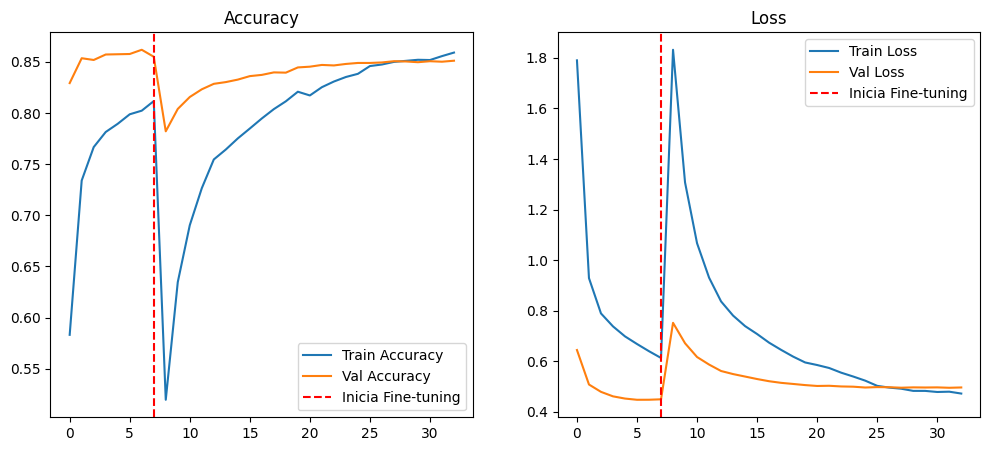

In [13]:
# Unimos los historiales para la gráfica
acc = history_a.history['accuracy'] + history_b.history['accuracy']
val_acc = history_a.history['val_accuracy'] + history_b.history['val_accuracy']
loss = history_a.history['loss'] + history_b.history['loss']
val_loss = history_a.history['val_loss'] + history_b.history['val_loss']

# Punto donde empezó el Fine-Tuning
split_point = len(history_a.history['accuracy'])

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Train Accuracy')
plt.plot(val_acc, label='Val Accuracy')
plt.axvline(x=split_point-1, color='r', linestyle='--', label='Inicia Fine-tuning')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.axvline(x=split_point-1, color='r', linestyle='--', label='Inicia Fine-tuning')
plt.legend()
plt.title('Loss')
plt.show()

## Prueba del modelo

In [3]:
# 1. Cargar el modelo
model = tf.keras.models.load_model('model\modelo_prediccion_perros_v1.keras')

# 2. Definir nombres de clases desde las carpetas (Evita el AttributeError)
class_names = sorted([f for f in os.listdir("dataset_recortado") if os.path.isdir(os.path.join("dataset_recortado", f))])

def predecir_raza_mezcla(img_path):
    # Cargar y preparar imagen
    img = tf.keras.utils.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) 

    # Predicción
    predictions = model.predict(img_array)[0]
    top_5_indices = np.argsort(predictions)[-5:][::-1]
    
    print(f"\n--- Análisis Pawsense (Top 5 Razas) ---")
    for i in top_5_indices:
        print(f"{class_names[i]}: {predictions[i]*100:.2f}%")

# Probar
predecir_raza_mezcla("perro_prueba3.jpg")

<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
C:\Users\enrim\AppData\Local\Temp\ipykernel_1088\4275249312.py:2: SyntaxWarning: invalid escape sequence '\m'
  model = tf.keras.models.load_model('model\modelo_prediccion_perros_v1.keras')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

--- Análisis Pawsense (Top 5 Razas) ---
miniature_schnauzer: 32.63%
Scottish_deerhound: 15.88%
standard_schnauzer: 13.55%
giant_schnauzer: 11.98%
Old_English_sheepdog: 5.53%


## Evaluación del modelo

In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    "dataset_recortado",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

# 2. Ahora ya puedes evaluar sin errores
print("Evaluando modelo en el set de validación...")
evaluacion = model.evaluate(val_ds)

print(f"\nResultado Global:")
print(f"Pérdida (Loss): {evaluacion[0]:.4f}")
print(f"Precisión Final (Accuracy): {evaluacion[1]*100:.2f}%")

Found 20580 files belonging to 120 classes.
Using 4116 files for validation.
Evaluando modelo en el set de validación...
129/129 ━━━━━━━━━━━━━━━━━━━━ 278s 2s/step - accuracy: 0.9206 - loss: 0.2735

Resultado Global:
Pérdida (Loss): 0.2735
Precisión Final (Accuracy): 92.06%
